Author: [Ahmed Sobhi](ahmedyousrisobhi@gmail.com)

Creation_data: 20th Jul 2023

Objective: Raw Data Eda

Data Column Description:
|Feature|Description|
|--|--|
|country| Country name, three unique countries.|
|article| 6 digit article number, as unique identifier of an article
|sales| total number of units sold in respective retail week
|regular_price| recommended retail price of the article.
|current_price| current selling price (weighted average over the week)
|ratio| price ratio as current_price/regular_price, such that price discount is 1-ratio
|retailweek| start date of the retailweek.
|promo1| indicator for media advertisement, taking 1 in weeks of activation and 0 otherwise
|promo2| indicator for store events, taking 1 in weeks with events and 0 otherwise
|customer_id| customer unique identifier, one id per customer
|article| 6 digit article number, as unique identifier of an article, 10 unique types or articles.
|productgroup| product group the article belongs to
|category| product category the article belongs to
|cost| total costs of the article (assumed to be fixed over time)
|style| description of article design.
|sizes| size range in which article is available.
|gender| gender of target consumer of the article.
|rgb_*_main_color| intensity of the red (r), green (g), and blue (b) primaries of the article‘s main color, taking values [0,250]
|rgb_*_sec_color| intensity of the red (r), green (g), and blue (b) primaries of the article‘s secondary color, taking values [0,250]
|label| advertisement result after offering/sending/presenting the offer to the customer. 0 means the customer did not buy and 1 means the costomer did buy

# Importing libararies and packages

In [45]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Used to create an statistical report regarding the input dataset.
from dataprep.eda import create_report

# Used to get convert RGB values into colours
import webcolors

# Required Function Definisions

In [46]:
# Plotting time series component
def plot_timeseries_trend(df:pd.DataFrame, timestamp_col:str, target_col:str, groupby_lst:list, fig_title:str='', save:bool=False)->None:
    """
        Plot price trend per input selected feature

        Input:
            df: pandas DataFrame, input dataset.
            timestamp_col: str, timestamp feature which will be x-axis.
            target_col: str, target featuers, which will be y-axis
            groupby_col: list, features which the dataset will be grouped by.
            fig_title: str, title of the plot
            save: boolean, indicate whether save or not to save the plot.

        Output:
            None.
    """

    # Create a copy of input dataframe
    _df = df.copy()

    # Group the data by category
    grouped_data = _df.sort_values(timestamp_col, ascending=True).groupby(groupby_lst)

    # Determine the number of categories
    num_categories = len(grouped_data)

    # Calculate the number of rows and columns for subplots
    num_rows = int(num_categories / 2) + num_categories % 2
    num_cols = 2

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    # Flatten the axes array to easily iterate through subplots
    axes = axes.flatten()

    # Plotting the trend for each category
    for i, (category, group) in enumerate(grouped_data):
        ax = axes[i]  # Select the appropriate subplot
        ax.plot(group[timestamp_col], group[target_col])
        ax.set_title(category)
        ax.set_xlabel('Time')
        ax.set_ylabel(target_col)

    # Hide empty subplots if necessary
    if num_categories < num_rows * num_cols:
        for j in range(num_categories, num_rows * num_cols):
            fig.delaxes(axes[j])
    
    plt.suptitle(fig_title)
    plt.tight_layout()  # Adjust the spacing between subplots
    
    if save==True:
        plt.savefig(f'../report/plots/{fig_title.replace(" ", "_")}.jpg')
    
    plt.show()

    return None


# Function for Plotting
def plot_numeric_features(df:pd.DataFrame, cols_to_drop:list, plot_type, save_plot:bool, plot_name:str) -> None:
    """
        Used to plot numerical featuers based on input selected plot.

        Input:
            df: pandas DataFrame, input dataframe.
            cols_to_drop: list, list of columns to drop.
            plot_type: function, define the plot type.
            save_plot: boolean, to whether save plot or not.
            plot_name: str, name of the figure.

        Output:
            None
    """

    # Select Numerical columns only
    features_numeric = (
        df.drop(cols_to_drop, axis=1)
        .select_dtypes('number')
        .columns.tolist()
    )

    # Calculate the number of rows and columns for subplots
    num_rows = int(len(features_numeric) / 2) + len(features_numeric) % 2
    num_cols = 2

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

    # Iterate over features and plot distplot on subplots
    for i, feature in enumerate(features_numeric):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        plot_type(df[feature], ax=ax)
        ax.set_title(f'{plot_type.__name__} of {feature.capitalize()}')

    # Remove empty subplots if necessary
    if len(features_numeric) % 2 != 0:
        fig.delaxes(axes[num_rows - 1, num_cols - 1])

    # Set title for the whole plot
    fig.suptitle(f'{plot_type.__name__} Analysis', fontsize=16)
    plt.tight_layout()

    # Save the plot
    if save_plot == True:
        try:
            plt.savefig(f'../report/plots/{plot_name}_{plot_type.__name__}.jpg')
        except FileNotFoundError:
            print('Wring file or file path')
            print('Creating new directory')
            # Create required directories
            if not os.path.exists('../report/plots'):
                os.makedirs('../report/plots/')
            plt.savefig(f'../report/plots/{plot_name}_{plot_type.__name__}.jpg')
        
    plt.show()

def plot_purchase_percentage(df:pd.DataFrame, target_col:str, feature_col:str, plot_save:bool=False):
    """
        Used to plot the distribution of the percentage of target column according to the feature column.

        PARAMETERS
            df: pandas DataFrame, Input dataset.
            target_col: str, Input target column name.
            feature_col: str, The column to which the calculating of percentage.
            plot_save: boolean, whether to save the plot of not.
        
        RETURN
            pandas DataFrame of calculated percentage.
    """

    # Calculate the total number of customers for each category
    total_customer_per_feature_col = df[feature_col].value_counts()

    # Calculate the number of customers with label==0 for each country
    label_0_per_feature_col = df[df[target_col] == 0][feature_col].value_counts()

    # Calculate the number of customers with label==1 for each country
    label_1_per_feature_col = df[df[target_col] == 1][feature_col].value_counts()

    # Calculate the percentage of customers with label==0 for each country
    label_0_per_feature_col = (label_0_per_feature_col / total_customer_per_feature_col) * 100

    # Calculate the percentage of customers with label==1 for each country
    label_1_per_feature_col = (label_1_per_feature_col / total_customer_per_feature_col) * 100

    # Create the DataFrame for the plot
    label_data = pd.DataFrame({
        feature_col: label_0_per_feature_col.index,
        'Label 0 Percentage': label_0_per_feature_col.values,
        'Label 1 Percentage': label_1_per_feature_col.values
    })

    # Plot the stacked bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=feature_col, y='Label 0 Percentage', data=label_data, color='lightcoral', label='Purchase Wihtout Promo')
    sns.barplot(x=feature_col, y='Label 1 Percentage', data=label_data, color='skyblue', bottom=label_data['Label 0 Percentage'], label='Purchase With Promo')
    plt.xlabel(feature_col)
    plt.ylabel('Percentage of Customers')
    plt.title(f'Percentage of Customers who purchase without & with promo by {feature_col}')
    plt.legend(title='Label', loc='upper right')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if plot_save == True:
        plt.savefig(f'../report/plots/Percentage of Customers who purchase without & with promo by {feature_col}.jpg')
    plt.show()

    return label_data


def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]


def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

# Loading Dataset

In [47]:
df = (
    pd.read_csv('../data/raw/full_gen_data.csv')
    .assign(
        retailweek = lambda x: pd.to_datetime(x.retailweek),
        customer_id = lambda x: x.customer_id.astype('int')
    )
    .rename(columns={
        'article':'article_id_1',
        'article.1':"article_id_2",
        'promo1':'promo_media_ads',
        'promo2':'promo_store_event',
        'cost':'cost_article_2'
    })
)

# Sorting by [Country, customer_id, retailweek]
df = df.sort_values(by=['country', 'customer_id', 'retailweek'])

df.head()

,country,article_id_1,sales,regular_price,current_price,ratio,retailweek,promo_media_ads,promo_store_event,customer_id,...,style,sizes,gender,rgb_r_main_col,rgb_g_main_col,rgb_b_main_col,rgb_r_sec_col,rgb_g_sec_col,rgb_b_sec_col,label
14560,Austria,LG5858,234,39.95,11.95,0.299124,2015-04-12,0,0,4001,...,slim,"xxs,xs,s,m,l,xl,xxl",women,205,104,57,255,187,255,0
14561,Austria,LG5858,234,39.95,11.95,0.299124,2015-04-12,0,0,4001,...,regular,"xxs,xs,s,m,l,xl,xxl",women,188,238,104,255,187,255,0
14562,Austria,LG5858,234,39.95,11.95,0.299124,2015-04-12,0,0,4001,...,regular,"xxs,xs,s,m,l,xl,xxl",women,205,173,0,255,187,255,0
14563,Austria,LG5858,234,39.95,11.95,0.299124,2015-04-12,0,0,4001,...,regular,"xxs,xs,s,m,l,xl,xxl",kids,205,140,149,164,211,238,0
14564,Austria,LG5858,234,39.95,11.95,0.299124,2015-04-12,0,0,4001,...,regular,"xxs,xs,s,m,l,xl,xxl",women,138,43,226,164,211,238,0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 14560 to 3799
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   country            100000 non-null  object        
 1   article_id_1       100000 non-null  object        
 2   sales              100000 non-null  int64         
 3   regular_price      100000 non-null  float64       
 4   current_price      100000 non-null  float64       
 5   ratio              100000 non-null  float64       
 6   retailweek         100000 non-null  datetime64[ns]
 7   promo_media_ads    100000 non-null  int64         
 8   promo_store_event  100000 non-null  int64         
 9   customer_id        100000 non-null  int64         
 10  article_id_2       100000 non-null  object        
 11  productgroup       100000 non-null  object        
 12  category           100000 non-null  object        
 13  cost_article_2     100000 non-null  float6

In [49]:
# Create a report for raw dataset
report = create_report(df)

# Save report locally
report.save('../report/reports/data_raw_report')

  0%|          | 0/2942 [00:00<?, ?it/s]

/home/yousri/anaconda3/envs/fixedsolution/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/yousri/anaconda3/envs/fixedsolution/lib/python3.9/site-packages/dataprep/eda/distribution/render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({col: [nrows - npresent]}, index=["Others"]))


Report has been saved to ../report/reports/data_raw_report.html!


Insights from the report:
- There are no physical actuall missing values in the dataset, So we should check for a logical missing values in features, which means that some dummy values to represent a feature which are not logical for that feature, So to solve this, we will consider it missing, and try to handle the missing values.
- There are skewness in following features [sales, regular_price, ratio].
- Timeseries data starting from 2014 till 2017.
- Feature: Sizes, Two unique values, to indicate either the customer choise store with multiple sizes varaity or not. Unfortunatly, in this dataset we can't determine which sizes are actually common.
- Women is the largest customer type in the dataset, But have they the highest selling?.
- A first impression from the data, It's shown that most of the sales are made without using the marketing campain, Also for the promos features, most of the data says that there were no promo at retail week.
  - We need to analysis the small percentage of customers who bought with promo, what makes them bought it.
  - Also, as the data shows that, there are a huge percentage of customers who already bought multiple time without any promos, So we need to invistige how to make them buy more with special promos related to them.

# Statistical Analysis

In [50]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sales,100000.0,56.781800,87.934743,1.000000,10.000000,26.000000,64.000000,898.00
regular_price,100000.0,52.391200,35.272128,3.950000,25.950000,40.950000,79.950000,197.95
current_price,100000.0,28.290800,22.578343,1.950000,11.950000,20.950000,37.950000,195.95
ratio,100000.0,0.545646,0.194363,0.296482,0.354839,0.525044,0.699248,1.00
promo_media_ads,100000.0,0.061900,0.240975,0.000000,0.000000,0.000000,0.000000,1.00
promo_store_event,100000.0,0.004900,0.069829,0.000000,0.000000,0.000000,0.000000,1.00
customer_id,100000.0,2721.726500,1908.085499,1.000000,1017.000000,2091.000000,4570.250000,5999.00
cost_article_2,100000.0,6.517000,3.914728,1.290000,2.290000,6.950000,9.600000,13.29
rgb_r_main_col,100000.0,161.400000,39.790147,79.000000,138.000000,160.000000,205.000000,205.00
rgb_g_main_col,100000.0,139.600000,63.641814,26.000000,104.000000,144.000000,181.000000,238.00


## Duplication Check

In [51]:
# Checking for complete row duplication
df[df.duplicated()]

,country,article_id_1,sales,regular_price,current_price,ratio,retailweek,promo_media_ads,promo_store_event,customer_id,...,style,sizes,gender,rgb_r_main_col,rgb_g_main_col,rgb_b_main_col,rgb_r_sec_col,rgb_g_sec_col,rgb_b_sec_col,label


- There are no complete duplication records in the dataset.
- We have 3 columns of unique ID ['article_id_1', 'article_id_2', 'customer_id'], but according to our case in this dataset, they could be possible to be duplicated, as the duplication here indicates that, the same customer could have multiple records as he\she buy multiple times different items from different articles, so accordingly the articles ids could have duplications aswell.

## Missing Values Check

In [52]:
df.isna().sum()

country              0
article_id_1         0
sales                0
regular_price        0
current_price        0
ratio                0
retailweek           0
promo_media_ads      0
promo_store_event    0
customer_id          0
article_id_2         0
productgroup         0
category             0
cost_article_2       0
style                0
sizes                0
gender               0
rgb_r_main_col       0
rgb_g_main_col       0
rgb_b_main_col       0
rgb_r_sec_col        0
rgb_g_sec_col        0
rgb_b_sec_col        0
label                0
dtype: int64

- As we discovered from the report above, there are no physically missing values, but we need to check if there are logical missing values.
- Exploring the other features, their values are logical, and there are no dummy values to be removed.

## Outliers Check
- Target is to check the outliers for selected featuers ['regular_price', 'current_price', 'ratio', 'cost']

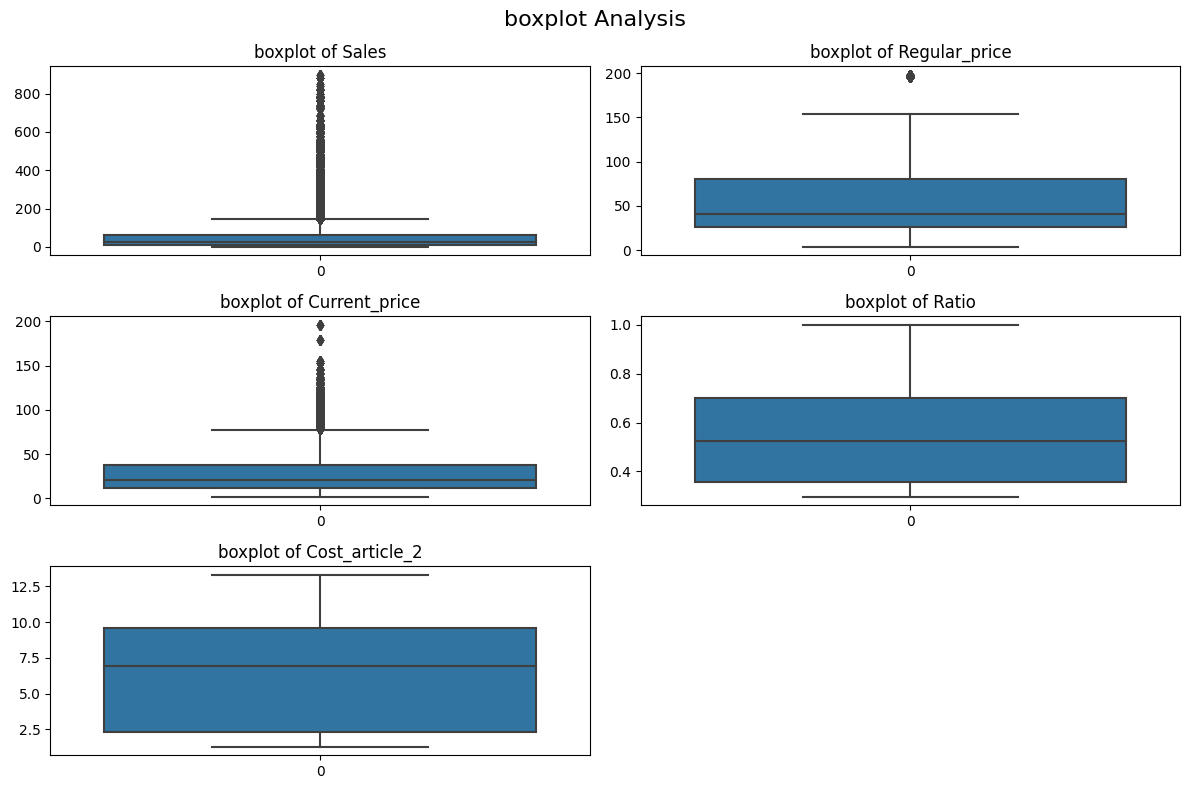

In [53]:
plot_numeric_features(
    df, 
    [
        'article_id_1', 'article_id_2', 'customer_id', 
        'rgb_r_main_col', 'rgb_g_main_col', 'rgb_b_main_col', 
        'rgb_r_sec_col', 'rgb_g_sec_col', 'rgb_b_sec_col',
        'promo_media_ads', 'promo_store_event', 'label'  
    ], 
    sns.boxplot, 
    False, 
    ''
    )

- There are outliers needs to be handled in ['sales', 'current_price']

## How many Unique Customers we have and How many products they bought?

In [54]:
# Count number of unique values for each categorical features
df_features_nunique = (
    df[['article_id_2', 'style', 'gender', 'category']]
    .nunique()
)

# According to each customer, calculate their status.
df_customer_status = (
        df.groupby(['customer_id']).agg(
        n_boughts=  ('label','count'),
        article_id_2= ('article_id_2', 'nunique'),
        style= ('style', 'nunique'),
        gender= ('gender', 'nunique'),
        category= ('category', 'nunique')
    ).reset_index()
)

# Check if customers have bought all types or not:
for col in df_features_nunique.index:    
    df_customer_status[f'bought_all_{col}'] = df_customer_status[col].apply(
        lambda row: 1 if row==df_features_nunique[col] else 0
    )

display(df_customer_status.head(3))

df_customer_status[['bought_all_article_id_2', 'bought_all_style', 'bought_all_gender', 'bought_all_category']].sum() == df_customer_status.shape[0]

,customer_id,n_boughts,article_id_2,style,gender,category,bought_all_article_id_2,bought_all_style,bought_all_gender,bought_all_category
0,1,10,10,3,4,6,1,1,1,1
1,2,10,10,3,4,6,1,1,1,1
2,3,40,10,3,4,6,1,1,1,1


bought_all_article_id_2    True
bought_all_style           True
bought_all_gender          True
bought_all_category        True
dtype: bool

- That data shows that, all the customers have bought from all the [articles_id_2, styles, genders, categories]

In [55]:
df_customer_status.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,4549.0,2914.510222,1835.463241,1.0,1243.0,2834.0,4598.0,5999.0
n_boughts,4549.0,21.982853,12.696258,10.0,10.0,20.0,30.0,80.0
article_id_2,4549.0,10.000000,0.000000,10.0,10.0,10.0,10.0,10.0
style,4549.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
gender,4549.0,4.000000,0.000000,4.0,4.0,4.0,4.0,4.0
category,4549.0,6.000000,0.000000,6.0,6.0,6.0,6.0,6.0
bought_all_article_id_2,4549.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
bought_all_style,4549.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
bought_all_gender,4549.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
bought_all_category,4549.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


## Promo usage Analysis

### Question: For applied promo during purchases, how much percentage were for promo_1 and promo_2?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


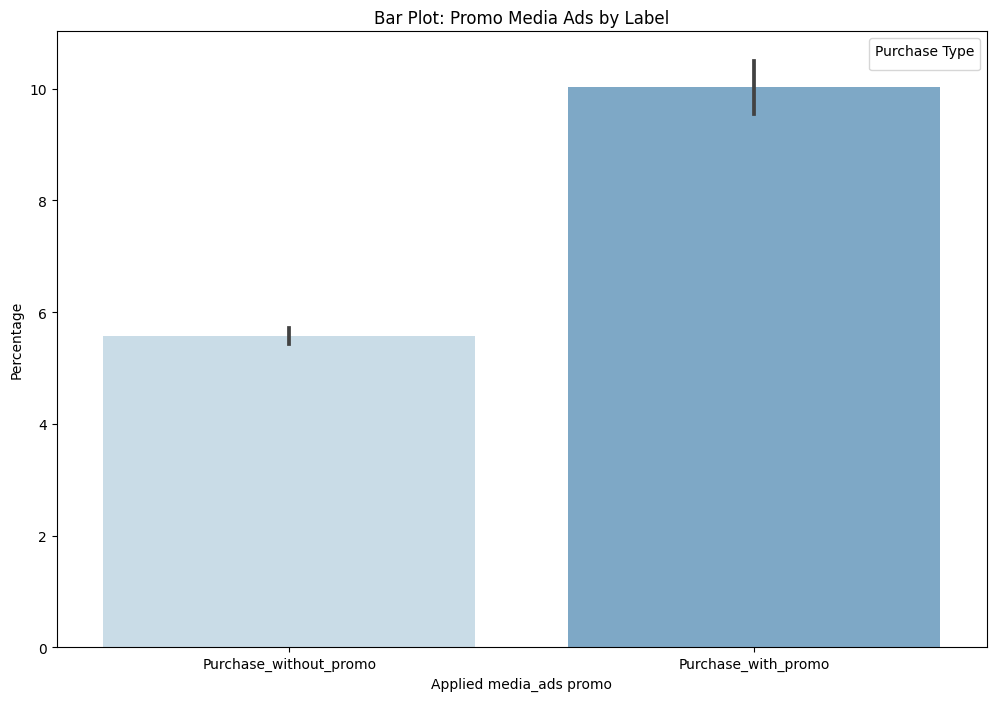

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


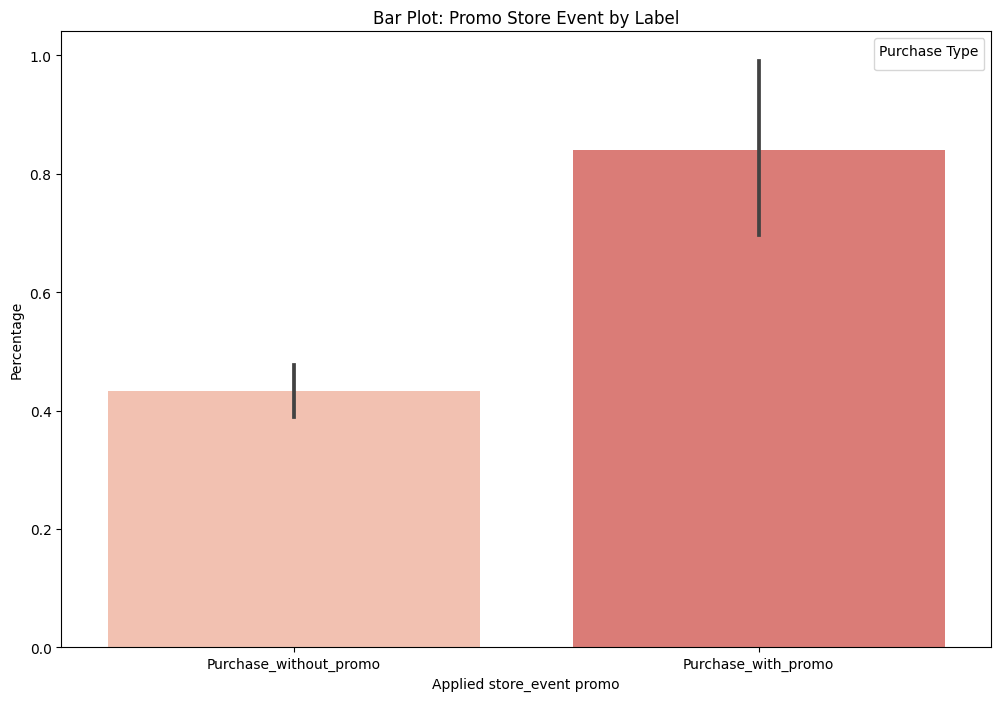

In [56]:
# Select a subset of dataframe of required columns
req_cols = ['label', 'promo_media_ads', 'promo_store_event']

# Create a subset of dataframe
df_plot = df[req_cols].copy()

df_plot['label_category'] = df_plot['label'].map({
    0: 'Purchase_without_promo',
    1: 'Purchase_with_promo'
})

# To be converted into percentage
df_plot[['promo_media_ads', 'promo_store_event']] *= 100

# Promo: media_ads

plt.figure(figsize=(12, 8))
# Bar plot
sns.barplot(x='label_category', y='promo_media_ads', data=df_plot, palette='Blues', alpha=0.7)

plt.xlabel('Applied media_ads promo')
plt.ylabel('Percentage')
plt.title('Bar Plot: Promo Media Ads by Label')
plt.legend(title='Purchase Type', loc='upper right')
plt.savefig('../report/plots/Bar Plot: Promo Media Ads by Label.jpg')
plt.show()

# Promo: store_event
plt.figure(figsize=(12, 8))

# Bar plot
sns.barplot(x='label_category', y='promo_store_event', data=df_plot, palette='Reds', alpha=0.7)

plt.xlabel('Applied store_event promo')
plt.ylabel('Percentage')
plt.title('Bar Plot: Promo Store Event by Label')
plt.legend(title='Purchase Type', loc='upper right')
plt.savefig('../report/plots/Bar Plot: Promo Store Event by Label.jpg')
plt.show()

Insights:
- 'Promo_media_ads': This promo was applied arount 6% during the purchases without promo, and around 10% during of the purchases with promo.
- 'Promo_store_event': This promo was applied arount 0.45% during the purchases without promo, and around 0.85% during of the purchases with promo. This indicates that, this promo was not applied much like the promo_media_ads.
- For both promos, the applied perecentage are high, so it is good indicator that the customers are willing to use them whenever they are applied.
- The verticle lines in the bars are called Error Lines, which means the hieght of the bar could vary depend on this verticle line, as it requires more data to accurately plot.

### Question: What are the percentage of promo usage According to each country?

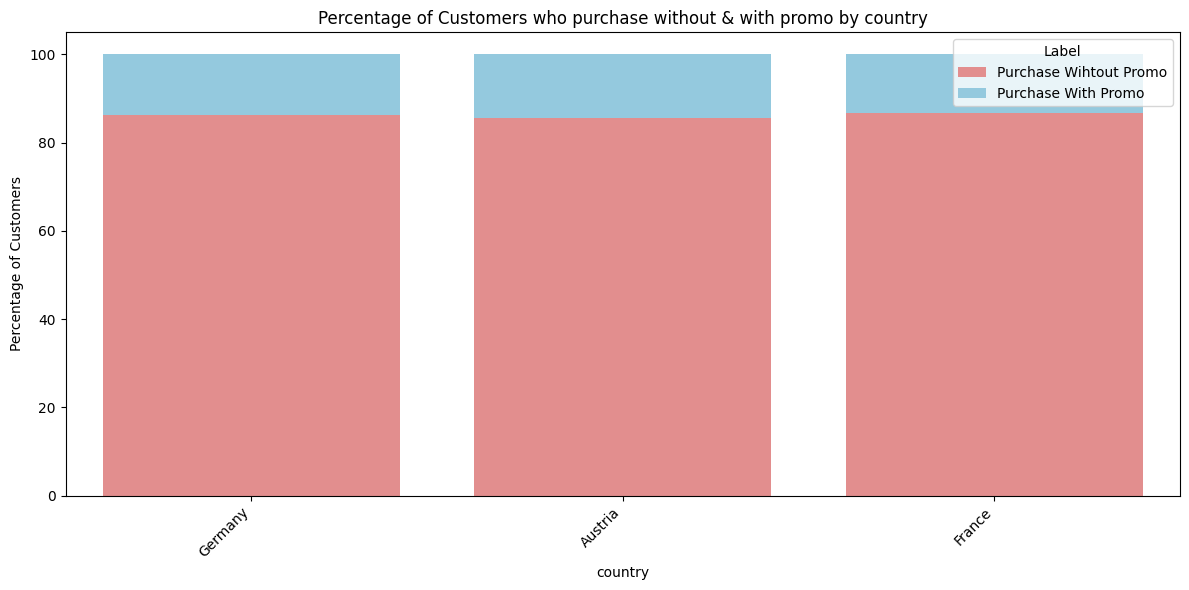

In [57]:
feature_col, target_col = 'country', 'label'
df_purchase_percentage_country = plot_purchase_percentage(df, target_col, feature_col, True)


In [58]:
df_purchase_percentage_country

,country,Label 0 Percentage,Label 1 Percentage
0,Germany,86.159919,13.840081
1,Austria,85.645987,14.354013
2,France,86.759379,13.240621


Insights:
- The distribution of promo usage in purchases across each country is almost similar, as around 14% of the purchase with promo, and the rest are without promo.
- This indicates all the country have similar behaviour of of promo, So if a new promo is applied, then all the country will be behave the same.

### Question: What is most used category with promos?

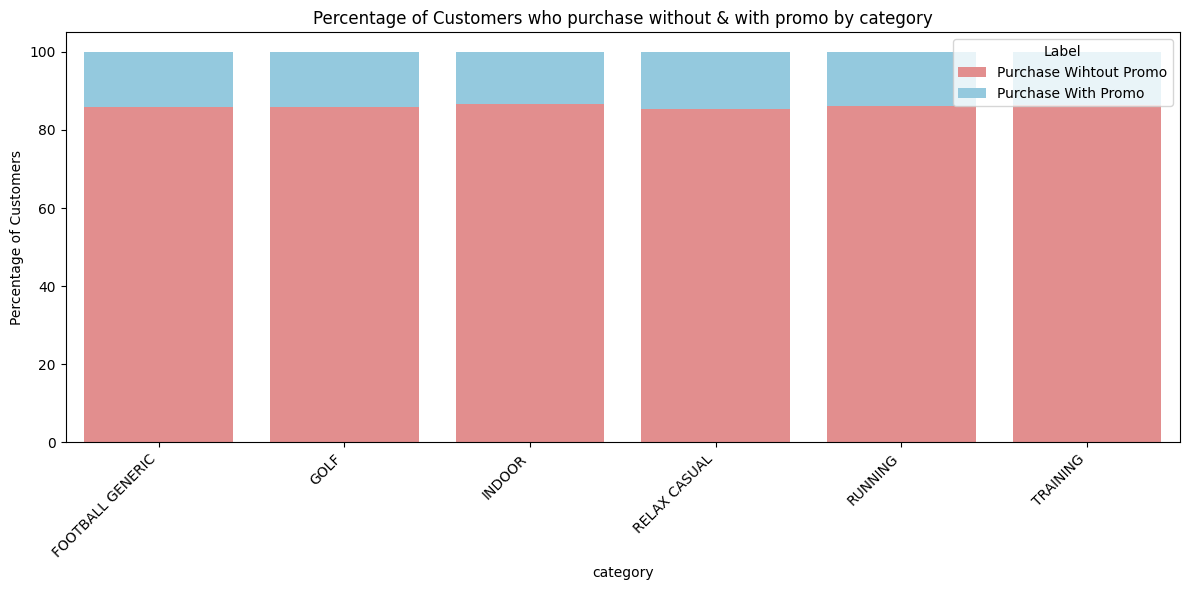

In [59]:
feature_col, target_col = 'category', 'label'
df_purchase_percentage_category = plot_purchase_percentage(df, target_col, feature_col, True)

In [60]:
df_purchase_percentage_category

,category,Label 0 Percentage,Label 1 Percentage
0,FOOTBALL GENERIC,85.990000,14.010000
1,GOLF,85.830000,14.170000
2,INDOOR,86.520000,13.480000
3,RELAX CASUAL,85.330000,14.670000
4,RUNNING,86.135000,13.865000
5,TRAINING,86.263333,13.736667


Insights:
- The same distibution for each category we have, the percentage is divided by [15% : 85%]

### Question: According to arcticle_2, which are the most used promo?

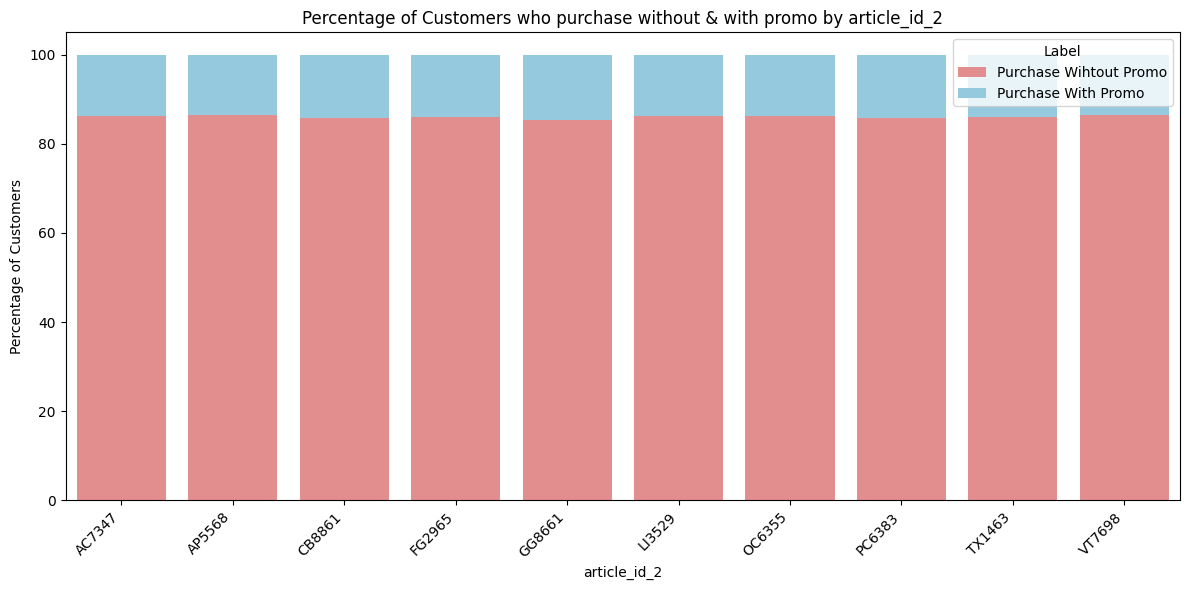

In [61]:
feature_col, target_col = 'article_id_2', 'label'
df_purchase_percentage_article2 = plot_purchase_percentage(df, target_col, feature_col, True)

### Question: What is more promo usage per sizes?

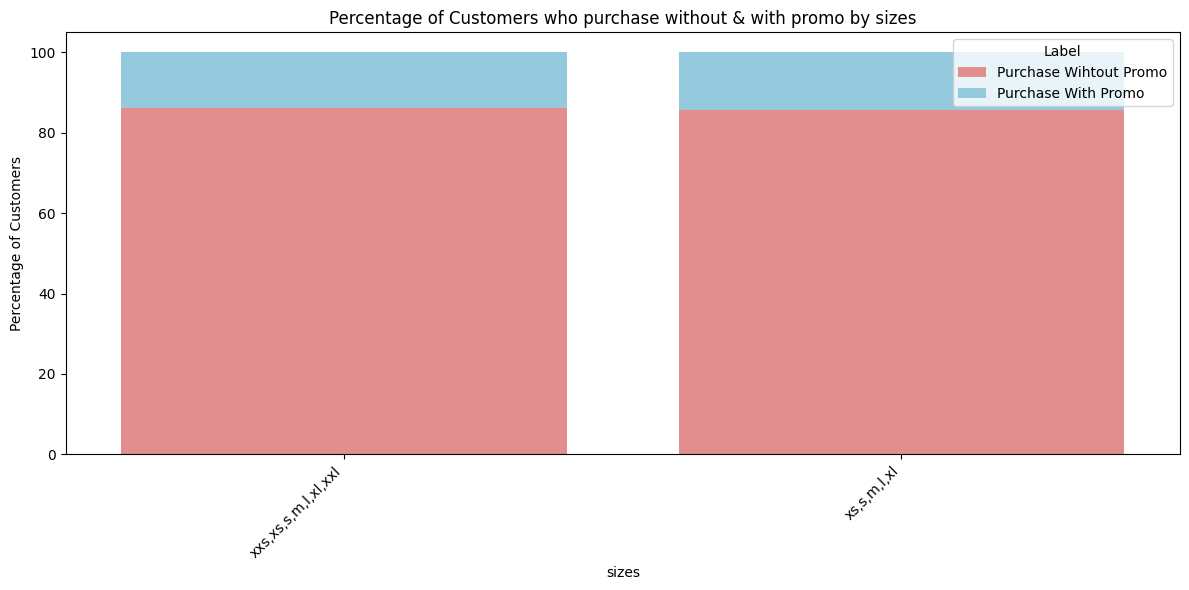

In [62]:
feature_col, target_col = 'sizes', 'label'
df_purchase_percentage_sizes = plot_purchase_percentage(df, target_col, feature_col, True)

In [63]:
df_purchase_percentage_sizes

,sizes,Label 0 Percentage,Label 1 Percentage
0,"xxs,xs,s,m,l,xl,xxl",86.108889,13.891111
1,"xs,s,m,l,xl",85.740000,14.260000


Insights:
- Even over the size types, they have the same percentage distribution across purchase without & with promos.

## Color features Analysis
- The RGB values for the primary and secondary articles in the dataset represent the intensity of the red, green, and blue primaries of the respective colors.

In [64]:
# Define main/secondary colours
main_color_cols = ['rgb_r_main_col', 'rgb_g_main_col', 'rgb_b_main_col'] 
sec_color_cols = ['rgb_r_sec_col', 'rgb_g_sec_col', 'rgb_b_sec_col']

# Calculate the closest color
df['main_closest_color'] = (
    df[main_color_cols].apply(lambda row: tuple(row), axis=1)
    .apply(get_colour_name)
    .apply(lambda row: row[1])
)

df['sec_closest_color'] = (
    df[sec_color_cols].apply(lambda row: tuple(row), axis=1)
    .apply(get_colour_name)
    .apply(lambda row: row[1])
)

In [66]:
df[['main_closest_color', 'sec_closest_color']].nunique()

main_closest_color    10
sec_closest_color      3
dtype: int64

In [67]:
df['main_closest_color'].unique(), df['sec_closest_color'].unique()

(array(['chocolate', 'darkkhaki', 'goldenrod', 'rosybrown', 'blueviolet',
        'steelblue', 'brown', 'lightskyblue', 'silver', 'gray'],
       dtype=object),
 array(['lavender', 'lightblue', 'rosybrown'], dtype=object))

### Question: What is the most popular color?

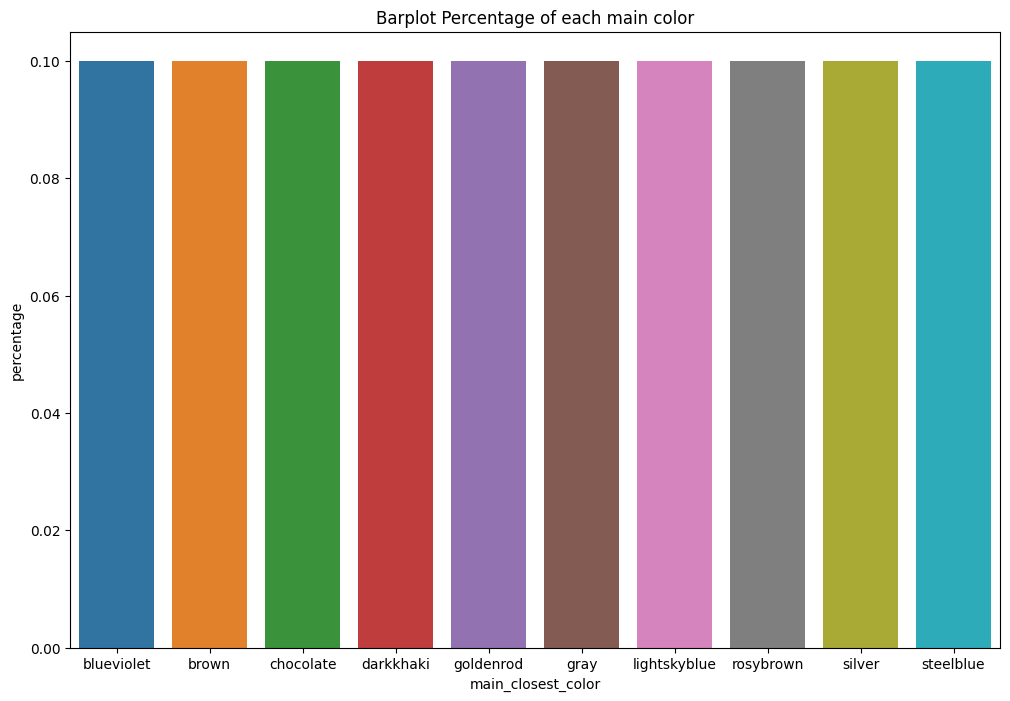

In [79]:
df_customer_color_percentage = (
    (
        df.groupby('main_closest_color').agg(
        {
            'customer_id':'count',
        }
        )/df.shape[0]
    ).reset_index()
    .rename(columns={'customer_id':'percentage'})
)

plt.figure(figsize=(12, 8))
sns.barplot(data=df_customer_color_percentage, x='main_closest_color', y='percentage')
plt.title('Barplot Percentage of each main color')
plt.savefig('../report/plots/Barplot Percentage of each main color.jpg')
plt.show()

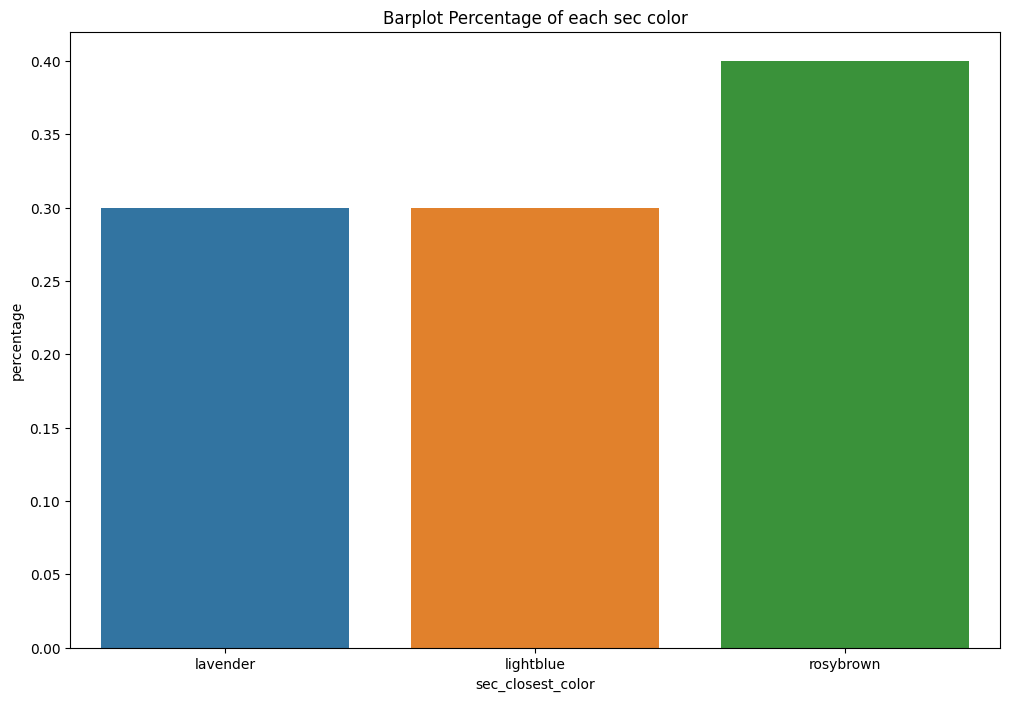

In [80]:
df_customer_color_percentage = (
    (
        df.groupby('sec_closest_color').agg(
        {
            'customer_id':'count',
        }
        )/df.shape[0]
    ).reset_index()
    .rename(columns={'customer_id':'percentage'})
)

plt.figure(figsize=(12, 8))
sns.barplot(data=df_customer_color_percentage, x='sec_closest_color', y='percentage')
plt.title('Barplot Percentage of each sec color')
plt.savefig('../report/plots/Barplot Percentage of each sec color.jpg')
plt.show()

Insights:
- The main colors are distributed equivally, unlike the secondary color, where rosybrown is the most popular in all of them.

### Question: Which main color has more promos applied during puchases?

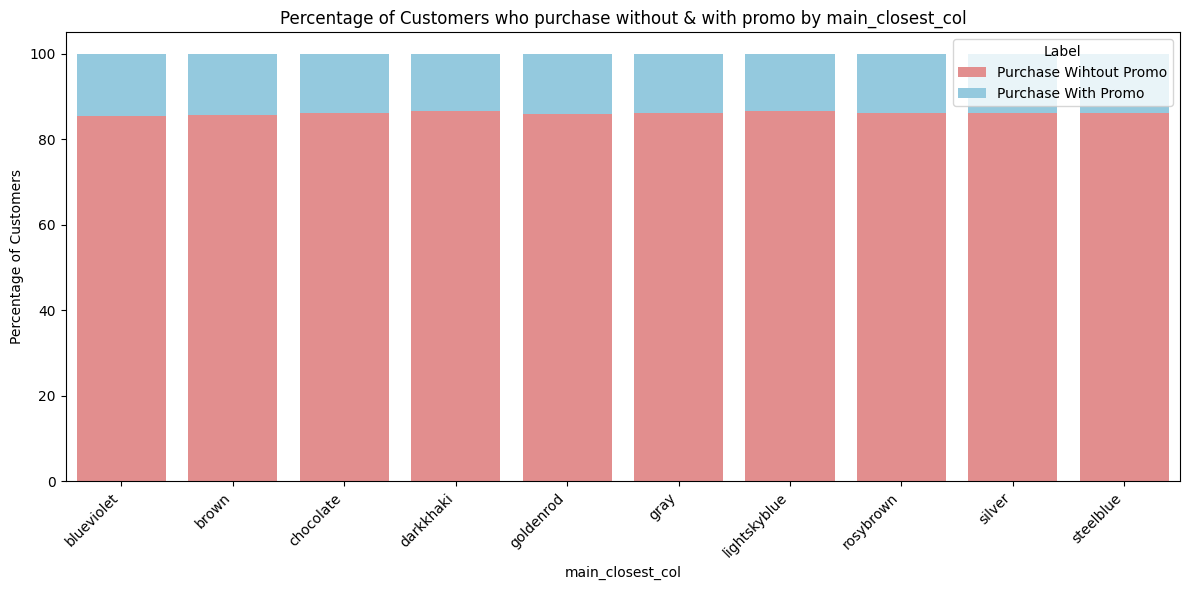

,main_closest_col,Label 0 Percentage,Label 1 Percentage
0,blueviolet,85.33,14.67
1,brown,85.74,14.26
2,chocolate,86.19,13.81
3,darkkhaki,86.49,13.51
4,goldenrod,85.83,14.17
5,gray,86.24,13.76
6,lightskyblue,86.52,13.48
7,rosybrown,86.24,13.76
8,silver,86.03,13.97
9,steelblue,86.11,13.89


In [88]:
feature_col, target_col = 'main_closest_col', 'label'
df_purchase_percentage_main_colour = plot_purchase_percentage(df, target_col, feature_col, False)
df_purchase_percentage_main_colour

## Data Distribution Check

In [28]:
# Select unique values in categorical columns
category_cols = df.select_dtypes('object').columns.tolist()

# Looping over each column of the category columns and check their unique values and their counts.
df_category_unique = df[category_cols].agg(
    ['nunique', 'unique']
).T 

df_category_unique

,nunique,unique
country,3,"[Germany, Austria, France]"
article_id_1,477,"[YN8639, CF3238, WR9459, EF2771, LX1494, VF673..."
article_id_2,10,"[OC6355, AP5568, CB8861, LI3529, GG8661, TX146..."
productgroup,4,"[SHOES, SHORTS, HARDWARE ACCESSORIES, SWEATSHI..."
category,6,"[TRAINING, GOLF, RUNNING, RELAX CASUAL, FOOTBA..."
style,3,"[slim, regular, wide]"
sizes,2,"[xxs,xs,s,m,l,xl,xxl, xs,s,m,l,xl]"
gender,4,"[women, kids, unisex, men]"


In [37]:
df.groupby('category').agg({'sizes':'unique'})

,sizes
category,
FOOTBALL GENERIC,"[xs,s,m,l,xl, xxs,xs,s,m,l,xl,xxl]"
GOLF,"[xxs,xs,s,m,l,xl,xxl]"
INDOOR,"[xxs,xs,s,m,l,xl,xxl]"
RELAX CASUAL,"[xxs,xs,s,m,l,xl,xxl]"
RUNNING,"[xxs,xs,s,m,l,xl,xxl]"
TRAINING,"[xxs,xs,s,m,l,xl,xxl]"


In [43]:
df.groupby(['gender']).agg({'category':'unique'})

,category
gender,
kids,[RUNNING]
men,[FOOTBALL GENERIC]
unisex,[FOOTBALL GENERIC]
women,"[TRAINING, GOLF, RELAX CASUAL, INDOOR, RUNNING]"


- Most of men are only interested in 'FOOTBALL GENERIC', But women are interested in all other categories.
- This explain why Women are the most higher gender who buys the products.

### How many category per artciles

In [84]:
df.groupby(['category']).agg({
    'article_id_2':['nunique', 'unique'],
    'gender':['nunique', 'unique'],
    'label':'count'
})


article_id_2                            gender  \
                      nunique                    unique nunique   
category                                                          
FOOTBALL GENERIC            2          [PC6383, AC7347]       2   
GOLF                        1                  [CB8861]       1   
INDOOR                      1                  [VT7698]       1   
RELAX CASUAL                1                  [GG8661]       1   
RUNNING                     2          [LI3529, FG2965]       2   
TRAINING                    3  [OC6355, AP5568, TX1463]       1   

                                 label  
                         unique  count  
category                                
FOOTBALL GENERIC  [unisex, men]  20000  
GOLF                    [women]  10000  
INDOOR                  [women]  10000  
RELAX CASUAL            [women]  10000  
RUNNING           [kids, women]  20000  
TRAINING                [women]  30000

### What is the most popular category?

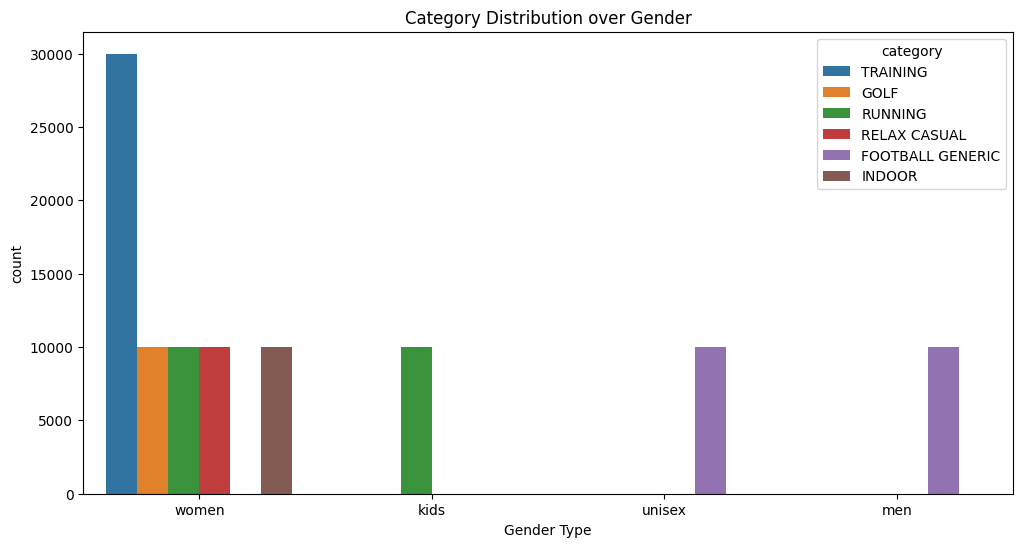

In [108]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df.reset_index(drop=True),
    x='gender',
    hue='category'
)
plt.title('Category Distribution over Gender')
plt.xlabel('Gender Type')
plt.savefig('../report/plots/category_distribution_over_gender.jpg')
plt.show()

Insights:
- Women are the highest gender type who bought almost all the categories, except 'FootBall Generic' category.

## Timeseries feature Exploration

/tmp/ipykernel_44200/537957800.py:38: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (category, group) in enumerate(grouped_data):


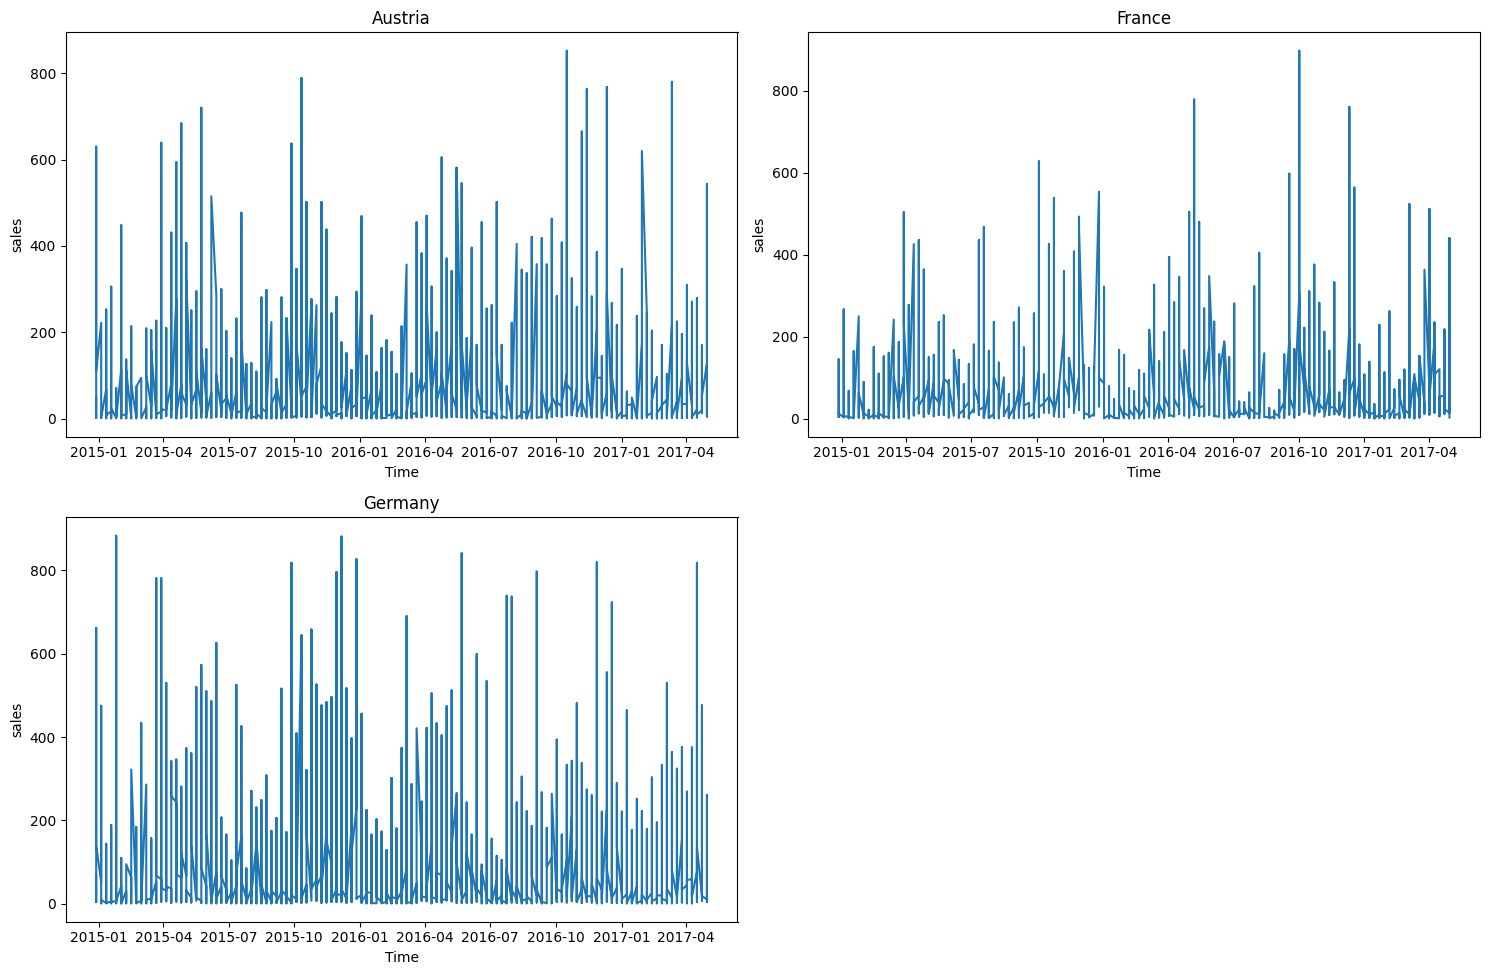

In [14]:
plot_timeseries_trend(df, 'retailweek', 'sales', ['country'])

/tmp/ipykernel_44200/537957800.py:38: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (category, group) in enumerate(grouped_data):


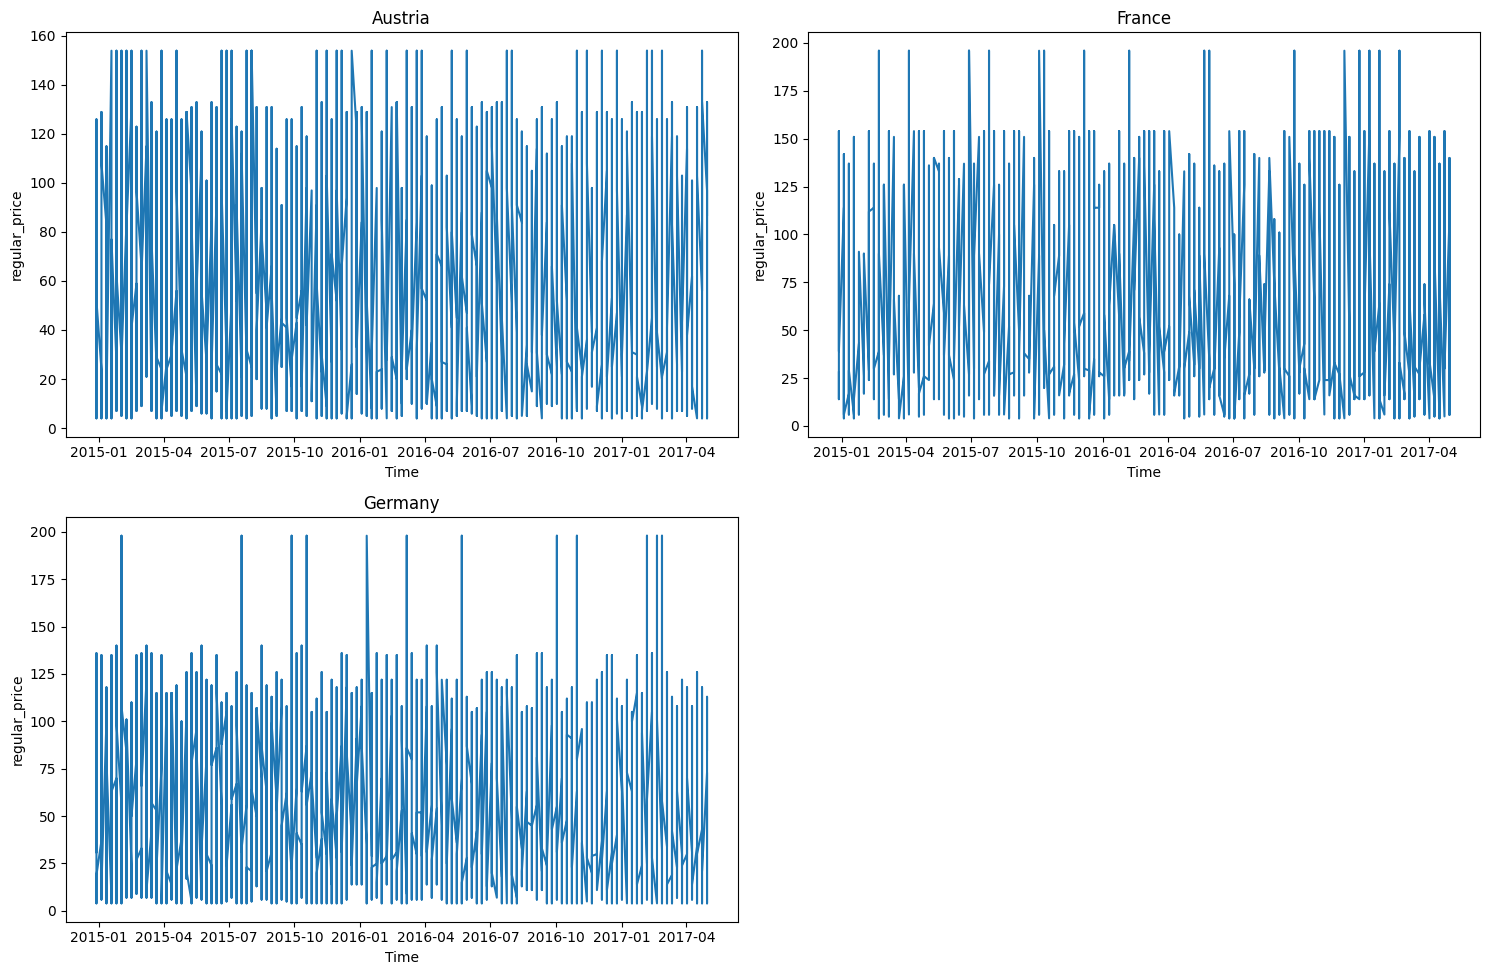

In [17]:
plot_timeseries_trend(df, 'retailweek', 'regular_price', ['country'])